In [1]:
from __future__ import division, print_function, absolute_import

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.io.ascii as at
import astropy.io.fits as fits
from astropy.table import Table

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import FK5  # Low-level frames
import astropy.units as u

import K2fov.projection as proj
import K2fov.fov as fov
from K2fov.K2onSilicon import angSepVincenty,getRaDecRollFromFieldnum

from matplotlib.patches import Circle

In [2]:
from hypra.utils import cat_io
from hypra.plot.plot_k2 import plot_chips, setup_k2_axes

In [3]:
home = os.getenv("HOME")
print(home)

/Users/sdouglas


# Set up existing data

In [4]:
pdat,pobs,pobsnr,pobsr = cat_io.get_data("P")
#print(pdat.dtype)
c5 = np.where((pdat["K2_TARGET"]>0))[0]
not_c5 = np.where((pdat["K2_TARGET"]<=0))[0]
print("{0} C5 targets, with {1} left over".format(len(c5),len(not_c5)))

844 C5 targets, with 325 left over


In [5]:
ppos = SkyCoord(pdat["RA"],pdat["DEC"],unit=u.degree)

In [6]:
c16_sfile = os.path.join(home,
                         "proposals/K2/Cycle5/siliconFlag_main_catalog.csv")
c16_silicon = at.read(c16_sfile)
c16 = np.asarray(c16_silicon["col3"][c16_silicon["col4"]==2],int)
c16_new = np.intersect1d(not_c5,c16)
print("{0}/{1} C16 targets that were not in C5".format(len(c16_new),len(c16)))

160/495 C16 targets that were not in C5


In [7]:
c5_prot = np.where((pdat["PERIOD"]>0) & (pdat["EPIC_ID"]>0))[0]
c16_repeat = np.intersect1d(c16,c5_prot)
print("{0} repeated rotators".format(len(c16_repeat)))

277 repeated rotators


In [10]:
single_figure = (9,8)
double_figure = (13,6)
double_stacked = (6,13)
triple_stacked = (6,14)
quad_square = (13,13)

std_ms = 9
std_mew = 1.5

cmap = plt.cm.inferno
old_color = plt.cm.Greys(0.5)
k2_color = "Crimson"

In [11]:
planet_eps = [211990866, 211913977, 211970147, 211822797, 211969807, 211901114, 211916756]

# Read in final field info

In [12]:
positions = []
star_type = []
field_no = []
status = []
file_centers = []

for i in [2,3,5]:
    field_file = "praef{0}tel_final.hydra".format(i)
    print(field_file)
    with open(field_file,"r") as f:
        for j in range(9):
            junk = f.readline()
        line = f.readline()
        file_centers.append(line[26:51])
        while line!="":
#             print(line)
            if ("STATUS=EDGE" in line):
                line=f.readline()
                continue
            pos = line[26:51]
            positions.append(pos)
            
            type0 = line[51:54]
            star_type.append(type0.strip())
            
            field_no.append(i)
            
            if ("STATUS=OK" in line):
                status.append("N")
            else:
                status.append("Y")
            
            line = f.readline()

praef2tel_final.hydra
praef3tel_final.hydra
praef5tel_final.hydra


In [13]:
print(file_centers)
center_pos = SkyCoord(file_centers,unit=(u.hourangle,u.degree))
print(center_pos.to_string("hmsdms"),center_pos.ra.to(u.degree))

[' 8 40 12.000  19 03 00.00', ' 8 40 19.757  19 28 00.00', ' 8 42 52.243  19 31 00.00']
['08h40m12s +19d03m00s', '08h40m19.757s +19d28m00s', '08h42m52.243s +19d31m00s'] [130d03m00s 130d04m56.355s 130d43m03.645s]


In [14]:
select_pos = SkyCoord(positions,unit=(u.hourangle,u.degree))
new_fields = SkyCoord(file_centers,unit=(u.hourangle,u.degree))

In [15]:
star_type = np.array(star_type)
field_no = np.array(field_no)
status = np.array(status)

print(np.where((field_no==3) & (status=="N"))[0])

[110 111 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 134 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 153 154 155 156 157 158 159 160 161 162 163 164 165 166 169 172
 174 179 180 181 182 184 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 213 215 216 217 218 219 220 221 222 223 224 234]


In [16]:
idx, sep, _ = select_pos.match_to_catalog_sky(ppos)
print(len(idx))

347


In [17]:
good_match = sep<(5*u.degree)
good_idx = idx[good_match]

field_idx = [idx[good_match & (status=="Y") & ((star_type=="O") | (star_type=="E"))
                 & (field_no==(i+1))] for i in range(6)]

In [18]:
print(field_idx)

[array([], dtype=int64), array([221, 447, 548, 716, 341, 199, 260, 825, 551, 387, 960, 507, 358,
       302, 352, 346, 316, 196, 192, 646, 237, 582, 456, 517, 509, 505,
       498, 493, 499, 570, 412, 437, 414, 661, 515, 699, 598, 379]), array([ 199,  210,  501,  230,  176, 1036,  468,  244,  258,  117,  960,
        477,  335,   75,  302,  309,  316,  196,  192,  195,  237,  226,
        456,  498,  412,  515,  797,  149,  598,  470,  377,  194,  140,
        680,  127]), array([], dtype=int64), array([344, 337, 892, 468, 235, 172, 475, 271, 363, 329, 323, 607, 243,
       633, 475, 900, 464, 546, 512, 498, 406, 555, 417, 698, 797, 149,
       465, 377, 222, 680]), array([], dtype=int64)]


In [19]:
initial_sample = idx[good_match & (status=="Y") & ((star_type=="O") | (star_type=="E"))]
c16_sample = np.intersect1d(initial_sample,c16)

In [20]:
mdwarfs = np.where((pdat["KH_MASS"]<0.65) & (pdat["KH_MASS"]>0) & 
                  (pdat["RPRIME"]>15.5) & (pdat["RPRIME"]<19.5))[0]
c16m = np.intersect1d(c16,mdwarfs)

mrot = np.intersect1d(mdwarfs, np.where((pdat["PERIOD"]>0))[0])

mfast = np.intersect1d(c16m, np.where((pdat["PERIOD"]>0) & (pdat["PERIOD"]<=8))[0])



# Plot the WIYN Sample

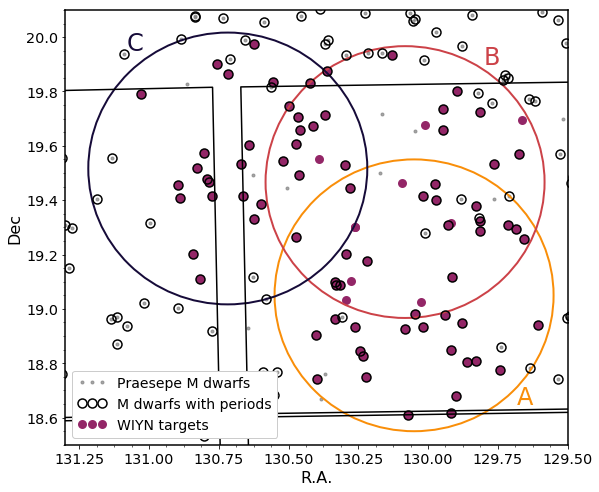

In [21]:
fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_chips(ax, 16)

# Plot all cluster members in that magnitude range
# Light grey dots
ax.plot(pdat["RA"][mdwarfs], pdat["DEC"][mdwarfs], ".", 
        color="Grey", alpha=0.7,label="Praesepe M dwarfs",
       ms=6,zorder=-111)


# Highlight targets with existing Prot
# Black edges
ax.plot(pdat["RA"][mrot], pdat["DEC"][mrot], "o",
        mec="k",mfc="None",mew=1.5,label="M dwarfs with periods",
       ms=std_ms)


# Highlight WIYN targets
# Colored circles
wiyn_color = cmap(0.4)
ax.plot(pdat["RA"][initial_sample], pdat["DEC"][initial_sample], 
       "o", color=wiyn_color,mec="None",label="WIYN targets",
       ms=std_ms,zorder=-11)

# Highlight simultaneous MDM targets
# Colored squares

setup_k2_axes(ax, extents=[129,132,17.3,20.5])
ax.tick_params(labelsize="x-large")

colors = [cmap(0.75),cmap(0.55),cmap(0.1)]
letters = "ABC"

for i,center in enumerate(center_pos):
    hydra = Circle((center.ra.value,center.dec.value),radius=0.5,color=colors[i],fill=False,lw=2)
    ax.add_patch(hydra)
    
    
leg = ax.legend(loc=3,numpoints=3)
leg.get_frame().set_alpha(1)

plt.savefig("fov_wide.eps",bbox_inches="tight")

ax.set_xlim(131.3,129.5)
ax.set_ylim(18.5,20.1)

ax.text(129.68,18.65,"A",color=colors[0],fontsize=24)
ax.text(129.8,19.9,"B",color=colors[1],fontsize=24)
ax.text(131.08,19.95,"C",color=colors[2],fontsize=24)

outfile = os.path.join(home,"my_papers/simspec/wiyn_fov.eps")
outfile = os.path.join(home,"my_papers/simspec/wiyn_fov.pdf")
plt.savefig(outfile,bbox_inches="tight")

# Read in and plot the MDM Sample

In [22]:
mdm_list = at.read("mdm_targets.txt",delimiter=",")
print(mdm_list.dtype)

[('idx', '<i8'), ('name', '<U13')]


In [23]:
mdm_idx = np.asarray(mdm_list["idx"],int)
print(len(mdm_idx))

38


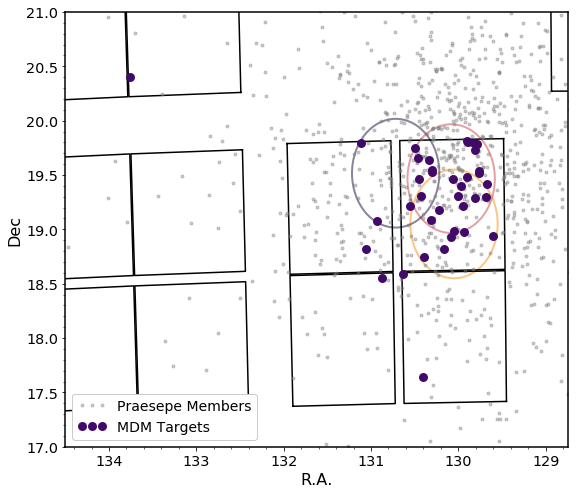

In [39]:
fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_chips(ax, 16)

setup_k2_axes(ax, extents=[128.75,134.5,17,21])
ax.tick_params(labelsize="x-large")

# Plot all Praesepe members
plt.plot(pdat["RA"],pdat["DEC"],".",color="Grey",alpha=0.4,
         label="Praesepe Members",ms=6)

# Highlight MDM Targets
mdm_color=cmap(0.2)
plt.plot(pdat["RA"][mdm_idx],pdat["DEC"][mdm_idx],"o",mec="None",
         mfc=mdm_color,label="MDM Targets",ms=std_ms)


colors = [cmap(0.75),cmap(0.55),cmap(0.1)]
letters = "ABC"

for i,center in enumerate(center_pos):
    hydra = Circle((center.ra.value,center.dec.value),radius=0.5,
                   color=colors[i],fill=False,lw=2,alpha=0.5)
    ax.add_patch(hydra)
    
    
leg = ax.legend(loc=3,numpoints=3)
leg.get_frame().set_alpha(1)

# plt.savefig("fov_wide.eps",bbox_inches="tight")

# ax.set_xlim(131.3,129.5)
# ax.set_ylim(18.5,20.1)

# ax.text(129.68,18.65,"A",color=colors[0],fontsize=24)
# ax.text(129.8,19.9,"B",color=colors[1],fontsize=24)
# ax.text(131.08,19.95,"C",color=colors[2],fontsize=24)

outfile = os.path.join(home,"my_papers/simspec/mdm_targets.eps")
outfile = os.path.join(home,"my_papers/simspec/mdm_targets.pdf")
plt.savefig(outfile,bbox_inches="tight")

In [82]:
outside = np.setdiff1d(mdm_idx,c16)
print(outside,pdat["LITNAME"][outside])

[] []


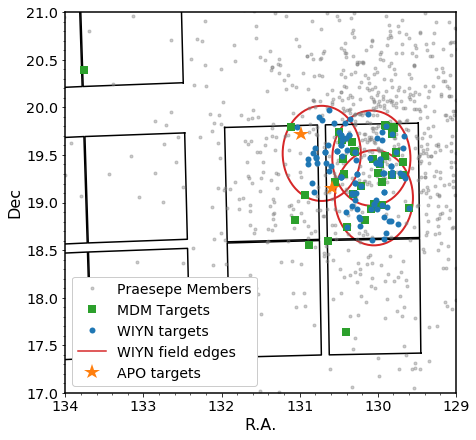

In [57]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
plot_chips(ax, 16)

setup_k2_axes(ax, extents=[129.5,134,17,21])
ax.tick_params(labelsize="x-large")

# Plot all Praesepe members
plt.plot(pdat["RA"],pdat["DEC"],".",color="Grey",alpha=0.4,
         label="Praesepe Members",ms=6)

# Highlight MDM Targets
plt.plot(pdat["RA"][mdm_idx],pdat["DEC"][mdm_idx],"s",mec="None",
         mfc="C2",label="MDM Targets",ms=8)

ax.plot(pdat["RA"][initial_sample], pdat["DEC"][initial_sample], 
       "o", color="C0",mec="None",label="WIYN targets",
       ms=6)


for i,center in enumerate(center_pos):
    hydra = Circle((center.ra.value,center.dec.value),radius=0.5,
                   color="C3",fill=False,lw=2)
    ax.add_patch(hydra)
    
ax.set_xticks(np.arange(129,134.1,1),minor=False)

ax.plot([],[],"-",color="C3",label="WIYN field edges")



# Highlight APO targets
apo = [211928486, 211966629]
loc = (pdat["EPIC_ID"]==apo[0]) | (pdat["EPIC_ID"]==apo[1])
ax.plot(pdat["RA"][loc], pdat["DEC"][loc], 
   "*", color="C1",mec="None",label="APO targets",
   ms=16,zorder=12)
    
leg = ax.legend(loc=3)
leg.get_frame().set_alpha(1)

outfile = os.path.join(home,"Dropbox/talks/posters/cs20_mdm_targets.pdf")
plt.savefig(outfile,bbox_inches="tight")

In [51]:
ax.set_xticks?